In [1]:
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from time import time
import sklearn.preprocessing
import numpy as np
import robust_onlinehd
from GenAttack import GenAttack

In [2]:
scaler = sklearn.preprocessing.Normalizer()

In [3]:
torch.manual_seed(54)

In [4]:

# loads simple mnist dataset
def load():  
    (x, y), (x_test, y_test) = mnist.load_data()


    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()   
    y = torch.from_numpy(y).long().squeeze()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()
    
    if len(x.shape) == 3:
        x = x.unsqueeze(3)
        x_test = x_test.unsqueeze(3)

    return x, x_test, y, y_test


print('Loading...')
x, x_test, y, y_test = load()

Loading...


In [5]:
criterias = [(0, 100, 0), (100, 150, 125), (150, 200, 175), (200, 256, 255)]
#criterias = []
kernel_size = 3
#kernel_size = 1
classes = y.unique().size(0)
features = x.size(1) * x.size(2)
model = robust_onlinehd.OnlineHD(criterias, kernel_size, scaler, classes, features, dim = 10000)


if torch.cuda.is_available():
    #x = x.cuda()
    #y = y.cuda()
    #x_test = x_test.cuda()
    #y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()

model = model.fit(x, y, bootstrap=.3, lr=0.095, epochs=300, batch_size=8196)
t = time() - t

print('Validating...')
yhat = model(x).cpu()
yhat_test = model(x_test).cpu()
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')


Using GPU!
Training...
Validating...
acc = 0.999567
acc_test = 0.969200
t = 29.229469


In [6]:
preds = model(x_test).cpu().numpy()
#preds = model(x).cpu().numpy()

In [7]:
targets = torch.randint(0, 10, preds.shape)
for i in tqdm(range(len(preds))):
    while targets[i] == preds[i]:
        targets[i] = torch.randint(0,10, (1,)).item()

100%|██████████| 10000/10000 [00:00<00:00, 53440.70it/s]


In [8]:
unif = torch.ones(targets.shape[0])
while True:
    indices = unif.multinomial(100)
    for idx in indices:
        if targets[idx] == y_test[idx]:
            break
    if idx == indices[-1] and targets[idx] != y_test[idx]:
        break
    else:
        indices = unif.multinomial(100)

In [9]:
attacker = GenAttack(model, classes, 28 * 28, model.scaler, 0.3, 'cuda')
N = 8                          # size of population to evolve
G = 5000                        # number of generations to evolve through
p = torch.FloatTensor([0.9])   # the parameter for Bernoulli distribution used in mutation
alpha = torch.FloatTensor([1.0]) # the parameter controlling mutation amount (step-size in the original paper)
delta = torch.FloatTensor([.9]) # the parametr controlling mutation amount (norm threshold in the original paper)

In [10]:
pops = []
results = []

In [11]:
t = time()
for i in tqdm(indices):
    temp = attacker.attack(x_test[i], targets[i], delta, alpha, p, N, G)
    pops.append(temp[0].numpy())
    results.append(temp[1])
t = time() - t

print(f'{t = :6f}')

  1%|          | 1/100 [00:27<45:28, 27.56s/it]

Attack Success at generation 2594


  2%|▏         | 2/100 [01:10<59:53, 36.66s/it]

Attack Success at generation 3789


  3%|▎         | 3/100 [01:51<1:02:15, 38.51s/it]

Attack Success at generation 3743


  4%|▍         | 4/100 [02:19<55:11, 34.50s/it]  

Attack Success at generation 2627


  5%|▌         | 5/100 [03:00<58:15, 36.80s/it]

Attack Success at generation 3705


  6%|▌         | 6/100 [03:23<50:31, 32.25s/it]

Attack Success at generation 2203


  7%|▋         | 7/100 [04:00<52:13, 33.69s/it]

Attack Success at generation 3372


  8%|▊         | 8/100 [04:35<52:15, 34.08s/it]

Attack Success at generation 3186


  9%|▉         | 9/100 [05:12<52:58, 34.93s/it]

Attack Success at generation 3457


 10%|█         | 10/100 [05:24<42:03, 28.03s/it]

Attack Success at generation 1179


 11%|█         | 11/100 [05:42<37:01, 24.96s/it]

Attack Success at generation 1706


 12%|█▏        | 12/100 [06:13<39:13, 26.74s/it]

Attack Success at generation 2896


 13%|█▎        | 13/100 [06:52<43:57, 30.31s/it]

Attack Success at generation 3636


 14%|█▍        | 14/100 [07:45<53:17, 37.18s/it]

Attack Success at generation 4923


 15%|█▌        | 15/100 [07:55<41:14, 29.11s/it]

Attack Success at generation 914


 16%|█▌        | 16/100 [08:48<50:51, 36.33s/it]

All 5000 generations failed.


 17%|█▋        | 17/100 [09:21<48:46, 35.26s/it]

Attack Success at generation 3013


 18%|█▊        | 18/100 [09:44<42:56, 31.42s/it]

Attack Success at generation 2110


 19%|█▉        | 19/100 [10:10<40:18, 29.86s/it]

Attack Success at generation 2332


 20%|██        | 20/100 [10:29<35:39, 26.74s/it]

Attack Success at generation 1660


 21%|██        | 21/100 [11:05<38:37, 29.34s/it]

Attack Success at generation 3088


 22%|██▏       | 22/100 [11:53<45:31, 35.02s/it]

Attack Success at generation 4354


 23%|██▎       | 23/100 [12:18<41:00, 31.96s/it]

Attack Success at generation 2325


 24%|██▍       | 24/100 [12:52<41:19, 32.62s/it]

Attack Success at generation 3195


 25%|██▌       | 25/100 [13:24<40:45, 32.61s/it]

Attack Success at generation 3057


 26%|██▌       | 26/100 [13:42<34:44, 28.17s/it]

Attack Success at generation 1651


 27%|██▋       | 27/100 [14:28<40:39, 33.42s/it]

Attack Success at generation 4243


 28%|██▊       | 28/100 [14:46<34:26, 28.71s/it]

Attack Success at generation 1654


 29%|██▉       | 29/100 [15:13<33:23, 28.22s/it]

Attack Success at generation 2525


 30%|███       | 30/100 [15:47<35:02, 30.03s/it]

Attack Success at generation 3211


 31%|███       | 31/100 [16:18<34:45, 30.23s/it]

Attack Success at generation 2902


 32%|███▏      | 32/100 [16:36<30:11, 26.64s/it]

Attack Success at generation 1618


 33%|███▎      | 33/100 [17:18<34:50, 31.20s/it]

Attack Success at generation 3869


 34%|███▍      | 34/100 [17:41<31:40, 28.79s/it]

Attack Success at generation 2160


 35%|███▌      | 35/100 [18:09<30:46, 28.41s/it]

Attack Success at generation 2569


 36%|███▌      | 36/100 [18:42<31:55, 29.94s/it]

Attack Success at generation 3149


 37%|███▋      | 37/100 [19:07<29:56, 28.52s/it]

Attack Success at generation 2391


 38%|███▊      | 38/100 [19:40<30:55, 29.92s/it]

Attack Success at generation 3119


 39%|███▉      | 39/100 [19:54<25:18, 24.89s/it]

Attack Success at generation 1234


 40%|████      | 40/100 [20:39<31:00, 31.02s/it]

Attack Success at generation 4223


 41%|████      | 41/100 [21:06<29:29, 29.99s/it]

Attack Success at generation 2582


 42%|████▏     | 42/100 [21:21<24:23, 25.24s/it]

Attack Success at generation 1335


 43%|████▎     | 43/100 [22:03<28:43, 30.24s/it]

Attack Success at generation 3908


 44%|████▍     | 44/100 [22:49<32:46, 35.11s/it]

Attack Success at generation 4292


 45%|████▌     | 45/100 [23:31<34:00, 37.10s/it]

Attack Success at generation 3573


 46%|████▌     | 46/100 [23:56<30:18, 33.67s/it]

Attack Success at generation 2195


 47%|████▋     | 47/100 [24:39<32:10, 36.42s/it]

Attack Success at generation 3871


 48%|████▊     | 48/100 [25:15<31:29, 36.33s/it]

Attack Success at generation 3388


 49%|████▉     | 49/100 [25:32<25:54, 30.48s/it]

Attack Success at generation 1562


 50%|█████     | 50/100 [26:03<25:35, 30.70s/it]

Attack Success at generation 2920


 51%|█████     | 51/100 [26:32<24:29, 30.00s/it]

Attack Success at generation 2671


 52%|█████▏    | 52/100 [27:04<24:31, 30.66s/it]

Attack Success at generation 3031


 53%|█████▎    | 53/100 [27:36<24:26, 31.21s/it]

Attack Success at generation 3064


 54%|█████▍    | 54/100 [27:51<20:02, 26.15s/it]

Attack Success at generation 1338


 55%|█████▌    | 55/100 [28:25<21:28, 28.63s/it]

Attack Success at generation 3216


 56%|█████▌    | 56/100 [28:52<20:34, 28.05s/it]

Attack Success at generation 2492


 57%|█████▋    | 57/100 [29:20<20:04, 28.01s/it]

Attack Success at generation 2594


 58%|█████▊    | 58/100 [30:14<25:03, 35.79s/it]

All 5000 generations failed.


 59%|█████▉    | 59/100 [31:00<26:38, 38.99s/it]

Attack Success at generation 4291


 60%|██████    | 60/100 [31:33<24:45, 37.14s/it]

Attack Success at generation 3079


 61%|██████    | 61/100 [31:55<21:08, 32.52s/it]

Attack Success at generation 2032


 62%|██████▏   | 62/100 [32:15<18:14, 28.79s/it]

Attack Success at generation 1889


 63%|██████▎   | 63/100 [33:08<22:10, 35.95s/it]

All 5000 generations failed.


 64%|██████▍   | 64/100 [33:16<16:38, 27.72s/it]

Attack Success at generation 820


 65%|██████▌   | 65/100 [33:36<14:51, 25.47s/it]

Attack Success at generation 1927


 66%|██████▌   | 66/100 [33:57<13:32, 23.90s/it]

Attack Success at generation 1937


 67%|██████▋   | 67/100 [34:24<13:41, 24.90s/it]

Attack Success at generation 2559


 68%|██████▊   | 68/100 [34:39<11:41, 21.92s/it]

Attack Success at generation 1393


 69%|██████▉   | 69/100 [34:53<10:04, 19.51s/it]

Attack Success at generation 1296


 70%|███████   | 70/100 [35:10<09:26, 18.88s/it]

Attack Success at generation 1609


 71%|███████   | 71/100 [36:04<14:15, 29.50s/it]

All 5000 generations failed.


 72%|███████▏  | 72/100 [36:40<14:34, 31.24s/it]

Attack Success at generation 3224


 73%|███████▎  | 73/100 [37:21<15:27, 34.36s/it]

Attack Success at generation 3682


 74%|███████▍  | 74/100 [37:39<12:43, 29.37s/it]

Attack Success at generation 1514


 75%|███████▌  | 75/100 [38:07<12:02, 28.90s/it]

Attack Success at generation 2407


 76%|███████▌  | 76/100 [38:48<12:59, 32.46s/it]

Attack Success at generation 3791


 77%|███████▋  | 77/100 [39:18<12:11, 31.82s/it]

Attack Success at generation 2844


 78%|███████▊  | 78/100 [39:46<11:13, 30.61s/it]

Attack Success at generation 2599


 79%|███████▉  | 79/100 [40:27<11:47, 33.71s/it]

Attack Success at generation 3736


 80%|████████  | 80/100 [40:47<09:56, 29.83s/it]

Attack Success at generation 1958


 81%|████████  | 81/100 [41:20<09:44, 30.76s/it]

Attack Success at generation 3089


 82%|████████▏ | 82/100 [42:09<10:50, 36.14s/it]

Attack Success at generation 4612


 83%|████████▎ | 83/100 [42:30<08:56, 31.54s/it]

Attack Success at generation 1958


 84%|████████▍ | 84/100 [42:52<07:37, 28.59s/it]

Attack Success at generation 2027


 85%|████████▌ | 85/100 [43:45<09:01, 36.09s/it]

All 5000 generations failed.


 86%|████████▌ | 86/100 [44:04<07:12, 30.92s/it]

Attack Success at generation 1758


 87%|████████▋ | 87/100 [44:18<05:36, 25.85s/it]

Attack Success at generation 1299


 88%|████████▊ | 88/100 [45:11<06:48, 34.06s/it]

All 5000 generations failed.


 89%|████████▉ | 89/100 [45:30<05:24, 29.48s/it]

Attack Success at generation 1759


 90%|█████████ | 90/100 [45:39<03:53, 23.30s/it]

Attack Success at generation 835


 91%|█████████ | 91/100 [46:32<04:50, 32.26s/it]

All 5000 generations failed.


 92%|█████████▏| 92/100 [47:23<05:03, 37.91s/it]

Attack Success at generation 4850


 93%|█████████▎| 93/100 [47:48<03:58, 34.06s/it]

Attack Success at generation 2350


 94%|█████████▍| 94/100 [48:18<03:15, 32.65s/it]

Attack Success at generation 2747


 95%|█████████▌| 95/100 [48:47<02:39, 31.82s/it]

Attack Success at generation 2750


 96%|█████████▌| 96/100 [49:07<01:53, 28.26s/it]

Attack Success at generation 1890


 97%|█████████▋| 97/100 [49:23<01:13, 24.52s/it]

Attack Success at generation 1496


 98%|█████████▊| 98/100 [49:36<00:41, 20.91s/it]

Attack Success at generation 1171


 99%|█████████▉| 99/100 [50:13<00:25, 25.95s/it]

Attack Success at generation 3553


100%|██████████| 100/100 [51:04<00:00, 30.65s/it]

Attack Success at generation 4732
t = 3064.634186


In [12]:
pops = np.array(pops)

In [13]:
sample_preds = preds[indices]

In [14]:
new_preds = []
for i in range(100):
    new_preds.append(model(torch.tensor(pops[i])).cpu().numpy())

In [15]:
success = 0
success_idx = []
for i in range(100):
    if targets[indices[i]].item() in new_preds[i]:
        success_idx.append((indices[i].item(), (i, np.where(new_preds[i] == targets[indices[i]].item())[0][0])))
        success += 1
print(success)

93


In [16]:
cache = {
    'indices' : indices,
    'sample_preds' : sample_preds,
    'pops' : np.array(pops),
    'hyper_parameter' : [N, G, p, alpha, delta],
    'success_idx' : success_idx,
    'model' : model, 
    'scaler' : model.scaler,
    'targets' : targets,
    'results' : results
}

In [17]:
torch.save(cache, 'robust_onlinehd_mnist.pt')

In [18]:
model(torch.tensor(pops[13]))

tensor([8, 8, 8, 8, 8, 6, 8, 8], device='cuda:0')

In [19]:
labels = {
    0 : '0',
    1 : '1',
    2 : '2',
    3 : '3',
    4 : '4',
    5 : '5',
    6 : '6',
    7 : '7',
    8 : '8',
    9 : '9'
}

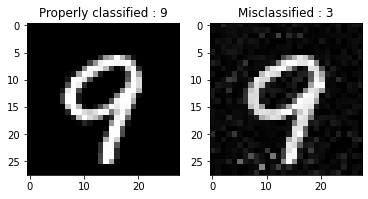

In [20]:
origin_idx, (new_idx, new_idx_idx) = success_idx[torch.randint(0, len(success_idx), (1,)).item()]

f, axes = plt.subplots(1, 2)
axes[0].imshow(x_test[origin_idx], cmap=plt.gray())
_ = axes[0].set_title('Properly classified : %s' % labels[sample_preds[new_idx].item()])
axes[1].imshow(pops[new_idx][new_idx_idx].astype(np.int32))
_ = axes[1].set_title('Misclassified : %s' % labels[new_preds[new_idx][new_idx_idx]])